# Basic Qiskit usage

Qiskit allows for the definition of basic quantum circuits to the most complicated state of the art techniques involving machine learning processes or hardware optimization routines. We will start the benchmark with a simplistic GHZ state coding circuit on its five qubit form:

$$\frac{|00000\rangle + |11111\rangle}{\sqrt{2}}$$

Therefore a five qubit circuit needs to be created. We can start by simply defining the first gate, a Hadamard gate that superposes one of our qubits into $$\frac{|0\rangle + |1\rangle}{\sqrt{2}}$$

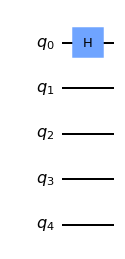

In [1]:
from qiskit import QuantumCircuit

circ = QuantumCircuit(5)

# Hadamard gate
circ.h(0)
circ.draw('mpl')

Now we can concatenate a set of CNOT gates so that we construct our expected quantum state.

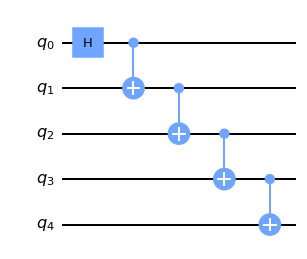

In [2]:
for i in range(0,4):
    circ.cx(i,i+1)
circ.draw('mpl')

We could locally simulate the outcome of this circuit and see if it matches our expectations. Qiksit provides several ways in which this can be visualized. By using the quantum_info module we can explore the effect of those gates being applied in our ideal quantum state.

In [3]:
import qiskit.quantum_info as qi
psi = qi.Statevector.from_instruction(circ)
psi.draw('latex', prefix='|\\psi\\rangle = ')

<IPython.core.display.Latex object>

Well, it seems to be well defined. We can explore other ways to visualize this very same state. For example, by its density operator so that we know if we are in the presence of a pure or mixed state.

In [4]:
rho = qi.DensityMatrix.from_instruction(circ)
rho.draw('latex', prefix='\\rho = ')

<IPython.core.display.Latex object>

Of course, our quantum devices will not have the ability to extract the quantum state to the classical domain so measurements will be needed in order to see if the output probability of each state coincides with the theoretical probability amplitude of our $|00000\rangle$ and $|11111\rangle$ states. For that, measurements will need to be added.

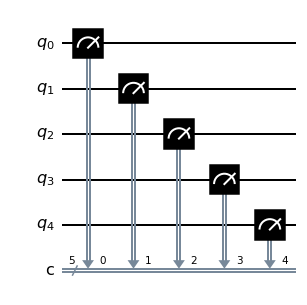

In [5]:
# Five quantum registers mapping 5 classical registers
meas = QuantumCircuit(5, 5)

# Measures
for i in range(5):
    meas.measure(i,i)
    
meas.draw('mpl')

Now we can concatenate the two to obtain our final circuit.

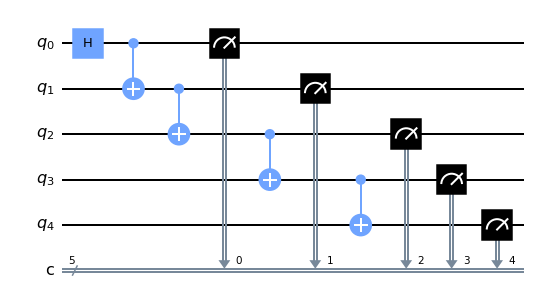

In [6]:
qc = QuantumCircuit(5, 5)
qc = qc.compose(circ)
qc.compose(meas, inplace=True)
qc.draw('mpl')

Let's try with a simulator. Qiskit provides also a local simulator that can be used to simulate the outcome of the circuit when running on a device.

In [7]:
from qiskit import Aer, execute

# execute the quantum circuit
backend = Aer.get_backend('qasm_simulator') # the device to run on
result = execute(qc, backend, shots=1000).result()
counts  = result.get_counts(qc)
print(counts)

{'00000': 495, '11111': 505}


We can see probabilities do not fully match the expected 50%-50%. This is given that we have sampled from this distirbution so increasing the number of shots should get closed to those figures.

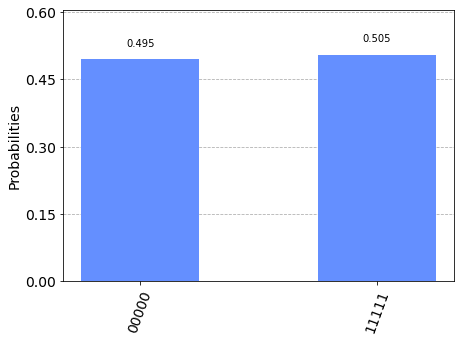

In [8]:
from qiskit.visualization import plot_histogram

plot_histogram(counts)

Let's try to simulate a real device and see what happends. We will need to set our credentials in order to identify ourselves against IBM's service. More information is available [here](https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq)

In [9]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
import os
from qiskit import IBMQ

# IBMQ.save_account(os.environ["TOKEN"])
IBMQ.load_account() # Load account from disk
IBMQ.providers()

We could check the systems available within IBM's service: https://quantum-computing.ibm.com/services?services=systems

In this case we will look for a 5 qubit system with less queue time.

In [11]:
from qiskit.providers.ibmq import least_busy

provider = IBMQ.get_provider(hub=os.environ["HUB"])
device = least_busy(
    provider.backends(
        filters=lambda x: x.configuration().n_qubits == 5  # 5 qubits
        and not x.configuration().simulator                # Not a simulator
        and x.status().operational == True                 # Operational backend
    )
)

In [12]:
config = device.configuration()

# Basic Features
print("This backend is called {0}, and is on version {1}. It has {2} qubit{3}. It "
    "{4} OpenPulse programs. The basis gates supported on this device are {5}."
    "".format(config.backend_name,
            config.backend_version,
            config.n_qubits,
            '' if config.n_qubits == 1 else 's',
            'supports' if config.open_pulse else 'does not support',
            config.basis_gates))

This backend is called ibmq_quito, and is on version 1.1.30. It has 5 qubits. It does not support OpenPulse programs. The basis gates supported on this device are ['id', 'rz', 'sx', 'x', 'cx', 'reset'].


We can see there are some specifics on the device we may need to consider. Let's first load the device model into our simulator and run our circuit 1000 times again to see what we get.

In [13]:
from qiskit.providers.aer import AerSimulator

sim = AerSimulator.from_backend(device)
result = sim.run(qc, shots=1000).result()
counts  = result.get_counts(qc)
print(counts)

{'11111': 353, '01000': 13, '00000': 431, '11000': 1, '10000': 15, '01101': 5, '00100': 23, '01111': 31, '11110': 11, '10111': 22, '11011': 24, '10101': 3, '11101': 20, '00010': 15, '00001': 10, '00110': 2, '00011': 4, '00101': 1, '01011': 3, '11001': 2, '11010': 3, '10100': 2, '00111': 3, '01110': 1, '10011': 1, '10010': 1}


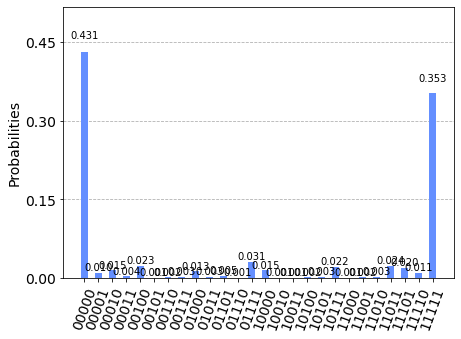

In [14]:
plot_histogram(counts)

Well, that's odd. Shouln't there be just two bars? This is what introducing noise to our quantum states does.

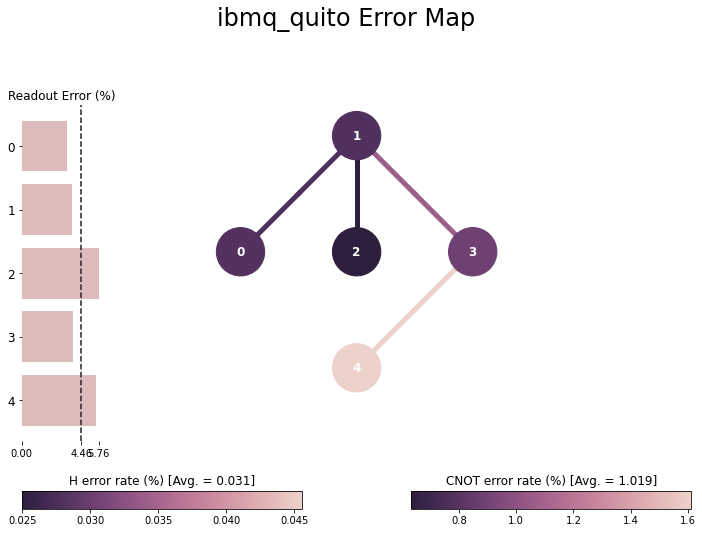

In [15]:
from qiskit.visualization import plot_error_map

plot_error_map(device)

You can notice that depending on where the gates are applied (which qubit) there is an error rate on those two gates we have used (Hadamard and CNOT). You may have noticed as well but some of the connections we have made do not exist... CNOT between 2 and 3? That cannot be done on this device. If you look at the basis gates ['id', 'rz', 'sx', 'x', 'cx', 'reset'] they do not include Hadamard gates. That means we need to adapt our code so that fits the restrictions of this device.

The translation of the logical circuit to a given device is called transpilation and it is a crucial part on any real device implementation.

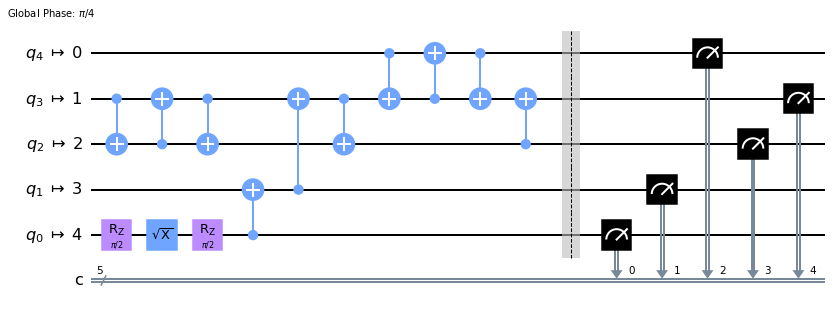

In [16]:
from qiskit import transpile

transpiled_circ = transpile(qc, device) 
transpiled_circ.draw('mpl')

Part of this complexity can be avoided if we already code our state with the device in mind.

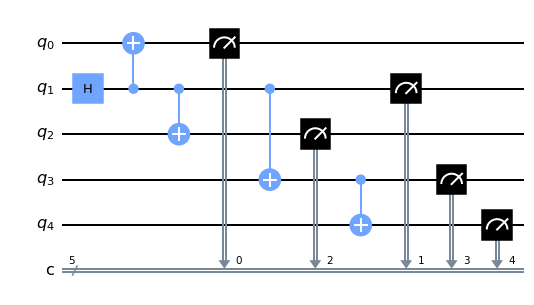

In [17]:
qc = QuantumCircuit(5, 5)
qc.h(1)
qc.cx(1,0)
qc.cx(1,2)
qc.cx(1,3)
qc.cx(3,4)
qc.measure([0,1,2,3,4], [0,1,2,3,4])
qc.draw('mpl')

In [18]:
backend = Aer.get_backend('qasm_simulator') # the device to run on
result = execute(qc, backend, shots=1000).result()
counts  = result.get_counts(qc)
print(counts)

{'00000': 498, '11111': 502}


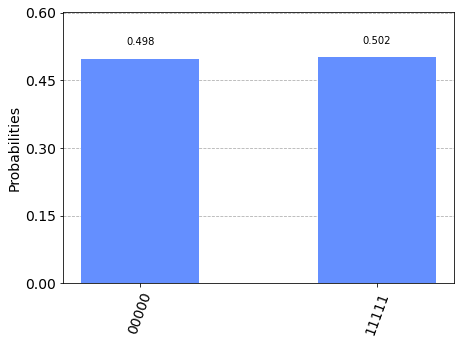

In [19]:
plot_histogram(counts)

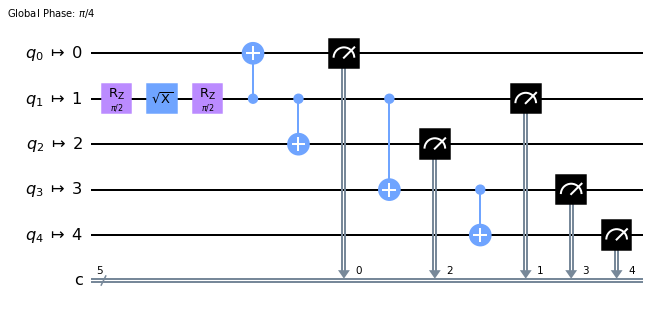

In [20]:
from qiskit import transpile

transpiled_circ = transpile(qc, device) 
transpiled_circ.draw('mpl')

In [21]:
job = device.run(transpiled_circ, shots=1000)

In [23]:
print(f"Job status: {job.status()}")

Job status: JobStatus.QUEUED


In [24]:
from qiskit.tools import job_monitor

job_monitor(job)

Job Status: job has successfully run


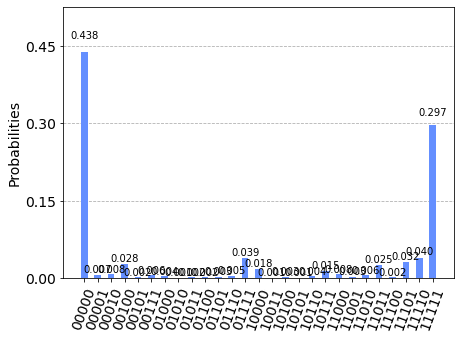

In [25]:
results = job.result()
counts = results.get_counts()
plot_histogram(counts)